# Проект по статистическому выводу

У нас есть данные по аренде велосипедов в Лондоне за два года: с 4 января 2015 по 3 января 2017. Эти данные нужно проанализировать.

### Цель проекта : 

- изучить динамику числа аренд

- изучить наличие связи с погодными условиями и выходными

- объяснить несколько аномалий на графике


**Имеются следующие данные в таблице:**

- timestamp – дата и время (точность до часа)
- cnt – количество аренд велосипедов за этот час
- t1 – температура, в С
- t2 – температура "ощущается как", в С 
- hum – влажность (%)
- wind_speed – скорость ветра, км/ч
- weather_code – погодные условия:
  - 1 – ясно (SKC)
  - 2 – преимущественно ясно / встречаются отдельные облака (SCT)
  - 3 – облачно / значительные облака (BKN)
  - 4 – пасмурно (OVC)
  - 7 – небольшой дождь Rain/ light Rain shower/ Light rain 
  - 10 – дождь с грозой
  - 26 – снегопад 
  - 94 – ледяной туман (да, такое бывает!)
- isholiday – является ли день праздником (1 – праздник, 0 – нет)
- isweekend –  является ли день выходным (1 – выходной, 0 – нет)
- season – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)


**В данном проекты я отвечу на следующие вопросы:** 

1. Загружу данные, проверю число наблюдений и столбцов, типы данных, наличие пропущенных значений. При необходимости – приведу переменные к нужным типам.

2. Построю график по числу поездок по дате и времени.

3. Преобразую данные и посчитаю число поездок по дням. Визуализирую результат.

4. Используя агрегированные данные по дням, посчитаю скользящее среднее с окном 3. 

5. Посчитаю разницу между наблюдаемыми и значениями, подсчитанными с помощью скользящего среднего, найду стандартное отклонение.
    
6. Определю границы 99% доверительного интервала, добавлю данную информацию в датафрейм.

7. Изучу аномально высокие значения и укажу день, когда число аренд было наибольшим. Найду причину данной аномалии.
    
8. Изучу аномально низкие значения, найду день с наименьшим числом аренд, а также причину данной аномалии.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

### 1. Загрузка и изучение данных

In [2]:
# считываем данные, смотрим их характеристики через метод info()

df = pd.read_csv('/Users/oksana_khoroshun/Documents/Python/london.csv') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [3]:
#смотрим первые 5 строк

df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [4]:
# поменяем формат колонки timestamp на datetime64

df['timestamp'] = pd.to_datetime(df['timestamp'])



В данных нет пропущенных значений.

### 2. Построение графика по числу поездок по дате и времени


 Для начала попробуем посмотреть на число поездок по датам и времени. Построим график, где:

- по оси x – дата (timestamp)
- по оси y – число поездок (cnt)


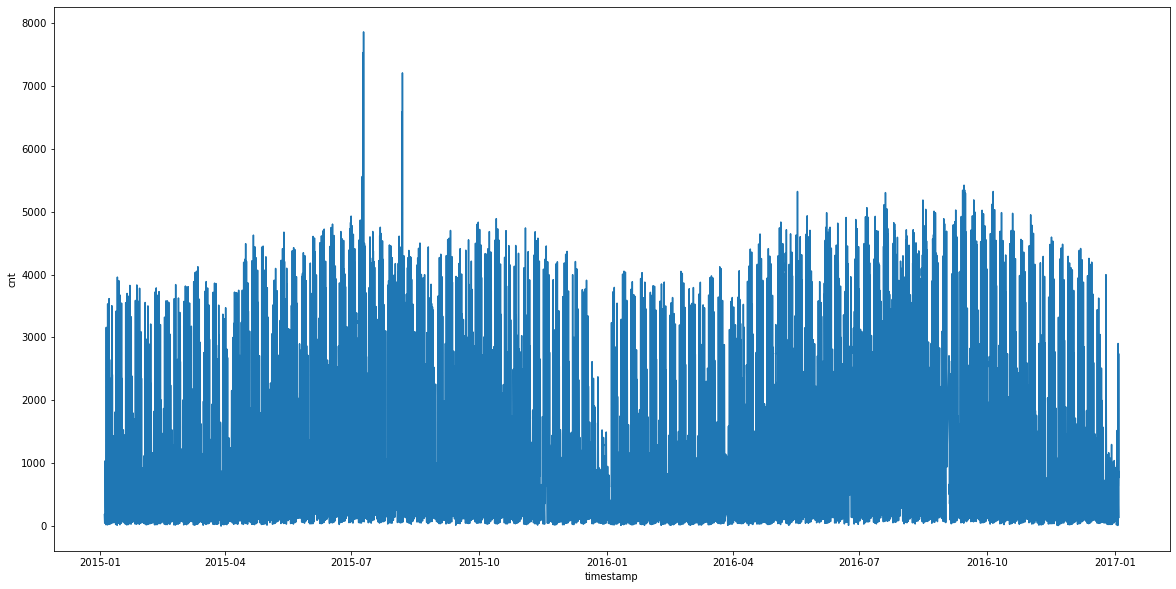

In [5]:
g = sns.lineplot(data=df, x='timestamp', y='cnt')

g.figure.set_figwidth(20)
g.figure.set_figheight(10)


По данному графику трудно что-либо понять. Нужно преобразовать данные, чтобы увидеть тренды.

### 3. Преобразование данных и вычисление числа поездок по дням. Визуализация результата

In [6]:
# агрегируем число поездок по дням 

dayly_summary = df.resample('D', on='timestamp').sum()

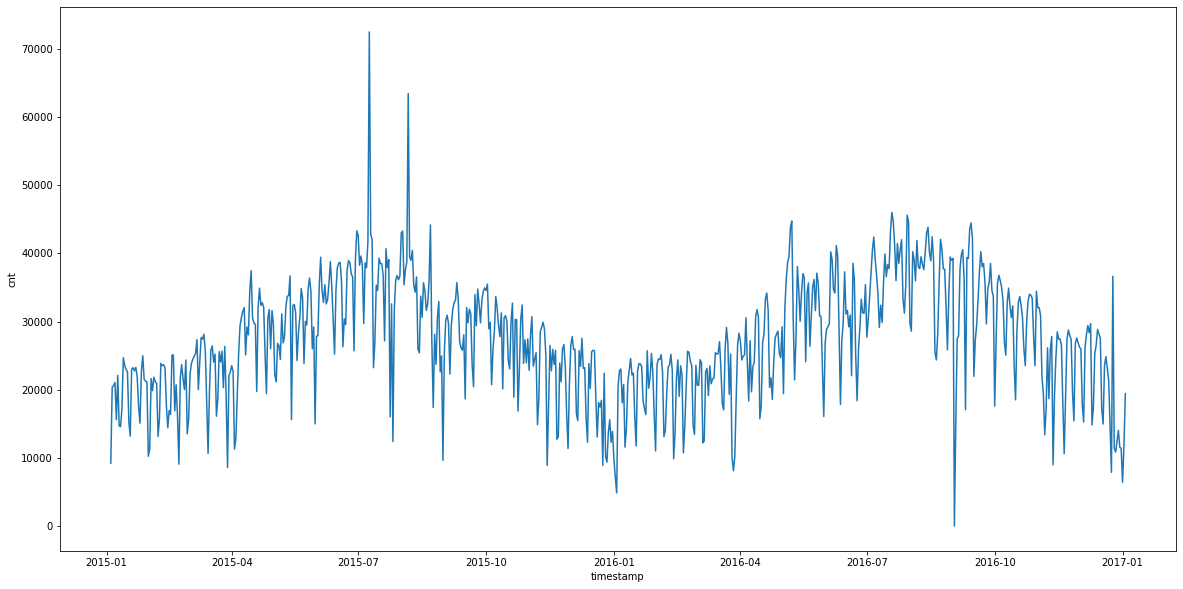

In [7]:
# визуализируем результат

g = sns.lineplot(data=dayly_summary, x='timestamp', y='cnt')

g.figure.set_figwidth(20)
g.figure.set_figheight(10)

Исходя из графика я делаю выводы о том, что:
    
- Зимой число аренд меньше, чем летом 

- Максимальное число аренд за день составляет более 70 000 

- Встречаются как очень резкие скачки числа аренд, так и падения 



### 4. Расчет скользящего среднего с окном 3, используя агрегированные данные по дням

In [8]:
# сбросим timestamp с индексов

dayly_summary = dayly_summary.reset_index()


In [9]:
# рассчитываем скользящее среднее с окном 3, помещая данные в новый столбец

dayly_summary['rolling_3'] = dayly_summary.cnt.rolling(window=3).mean()

dayly_summary.head(10)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,rolling_3
0,2015-01-04,9234,59.5,15.5,2262.5,180.0,69.0,0.0,24.0,72.0,NaN
1,2015-01-05,20372,193.0,161.0,1927.5,212.5,80.0,0.0,0.0,72.0,NaN
2,2015-01-06,20613,188.5,128.0,1893.5,384.0,74.0,0.0,0.0,72.0,16739.666667
3,2015-01-07,21064,171.5,103.5,1796.5,454.5,60.0,0.0,0.0,69.0,20683.000000
4,2015-01-08,15601,234.0,187.0,1903.5,491.5,84.0,0.0,0.0,72.0,19092.666667
5,2015-01-09,22104,305.5,296.0,1796.5,790.0,89.0,0.0,0.0,72.0,19589.666667
6,2015-01-10,14709,251.5,209.0,1587.0,823.5,65.0,0.0,24.0,72.0,17471.333333
7,2015-01-11,14575,159.5,59.0,1622.0,637.5,65.0,0.0,24.0,72.0,17129.333333
8,2015-01-12,17199,267.0,234.0,1838.0,676.5,118.0,0.0,0.0,72.0,15494.333333
9,2015-01-13,24697,206.5,146.0,1819.5,509.0,105.0,0.0,0.0,72.0,18823.666667


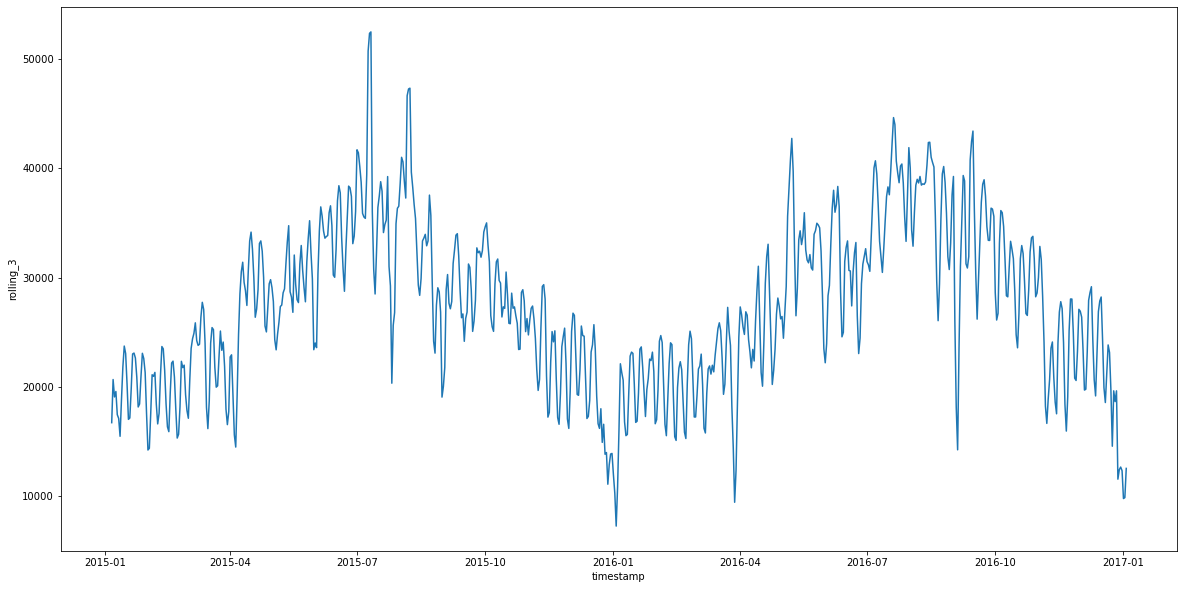

In [10]:
# визуализируем результат

g = sns.lineplot(data=dayly_summary, x='timestamp', y='rolling_3') 
g.figure.set_figwidth(20)
g.figure.set_figheight(10)

In [11]:
# найдем скользящее среднее для даты 2015-07-09

dayly_summary.query("timestamp == '2015-07-09'")

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,rolling_3
186,2015-07-09,72504,427.0,421.0,1175.5,311.5,28.0,0.0,0.0,24.0,50705.0


### 5. Расчет разницы между наблюдаемыми и значениями, подсчитанными с помощью скользящего среднего, вычисление стандартного отклонения.

In [12]:
# посчитаем разницу между наблюдаемыми и подсчитанными значениями

dayly_summary['diff'] = dayly_summary.cnt - dayly_summary.rolling_3

In [13]:
# вычислим стандартное отклонение

std = np.std(dayly_summary['diff'])

In [14]:
round(std, 2)

4558.59

### 6. Определение границ 99% доверительного интервала

Теперь определим границы интервалов. Для этого нужно взять данные, полученные при расчете скользящего среднего, и создать следующие объекты:

- upper_bound – верхняя граница; к средним прибавляем 2.576∗std
- lower_bound – нижняя граница; вычитаем 2.576∗std

In [15]:
# полученные значения запишeм в новые столбцы датафрейма с агрегированными данными

dayly_summary['upper_bound'] = dayly_summary.rolling_3 + 2.576*std

dayly_summary['lower_bound'] = dayly_summary.rolling_3 - 2.576*std


In [16]:
dayly_summary

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,rolling_3,diff,upper_bound,lower_bound
0,2015-01-04,9234,59.5,15.5,2262.5,180.0,69.0,0.0,24.0,72.0,NaN,NaN,NaN,NaN
1,2015-01-05,20372,193.0,161.0,1927.5,212.5,80.0,0.0,0.0,72.0,NaN,NaN,NaN,NaN
2,2015-01-06,20613,188.5,128.0,1893.5,384.0,74.0,0.0,0.0,72.0,16739.666667,3873.333333,28482.585854,4996.747479
3,2015-01-07,21064,171.5,103.5,1796.5,454.5,60.0,0.0,0.0,69.0,20683.000000,381.000000,32425.919188,8940.080812
4,2015-01-08,15601,234.0,187.0,1903.5,491.5,84.0,0.0,0.0,72.0,19092.666667,-3491.666667,30835.585854,7349.747479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2016-12-30,11566,78.5,25.5,2368.5,216.0,105.0,0.0,0.0,72.0,12682.000000,-1116.000000,24424.919188,939.080812
727,2016-12-31,11424,178.5,121.0,2183.0,319.5,98.0,0.0,24.0,72.0,12347.333333,-923.333333,24090.252521,604.414146
728,2017-01-01,6421,168.0,106.5,2122.5,339.0,150.0,0.0,24.0,72.0,9803.666667,-3382.666667,21546.585854,-1939.252521
729,2017-01-02,11823,89.5,22.5,1995.5,268.0,29.0,24.0,0.0,72.0,9889.333333,1933.666667,21632.252521,-1853.585854


### 7. Изучение аномально высоких значений. Причина данной аномалии

In [17]:
# выведем наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99%, то есть число 
# аренд оказалось выше ожидаемого

dayly_summary.query("cnt > upper_bound")

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,rolling_3,diff,upper_bound,lower_bound
186,2015-07-09,72504,427.0,421.0,1175.5,311.5,28.0,0.0,0.0,24.0,50705.000000,21799.000000,62447.919188,38962.080812
214,2015-08-06,63468,466.5,466.5,1625.0,357.5,50.0,0.0,0.0,24.0,46627.333333,16840.666667,58370.252521,34884.414146
609,2016-09-04,27512,452.5,452.5,1676.5,561.5,71.0,0.0,24.0,48.0,14259.000000,13253.000000,26001.919188,2516.080812
721,2016-12-25,36653,300.0,300.0,1906.0,664.0,87.0,0.0,24.0,72.0,19650.666667,17002.333333,31393.585854,7907.747479


9 июля 2015 года было наибольшее число аренд велосипедов - 72 504! Оказывается в этот день была забастовка работников метрополитена, которая привела к транспортному коллапсу в британской столице. Подробнее об этом можно прочитать на https://www.bbc.com/russian/international/2015/07/150709_london_tube_strike

### 8. Изучение аномально низких значений. Причина данной аномалии

In [18]:
# выведем наблюдения, для которых наблюдаемые значения оказались меньше верхней границы 99%, то есть число 
# аренд оказалось ниже ожидаемого

dayly_summary.query("cnt < lower_bound")

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,rolling_3,diff,upper_bound,lower_bound
130,2015-05-14,15609,237.5,189.5,2039.0,513.0,118.0,0.0,0.0,0.0,28709.333333,-13100.333333,40452.252521,16966.414146
189,2015-07-12,23240,444.5,444.5,1811.5,520.5,80.0,0.0,24.0,24.0,36036.666667,-12796.666667,47779.585854,24293.747479
201,2015-07-24,16034,380.5,380.5,1810.0,275.0,108.0,0.0,0.0,24.0,31013.666667,-14979.666667,42756.585854,19270.747479
232,2015-08-24,17400,380.0,380.0,2099.0,321.0,126.0,0.0,0.0,24.0,29529.333333,-12129.333333,41272.252521,17786.414146
314,2015-11-14,8898,270.0,235.0,1951.0,560.0,105.0,0.0,24.0,48.0,21037.333333,-12139.333333,32780.252521,9294.414146
607,2016-09-02,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26086.333333,-26086.333333,37829.252521,14343.414146
615,2016-09-10,17080,460.0,460.0,1932.0,392.0,89.0,0.0,24.0,48.0,31262.000000,-14182.000000,43004.919188,19519.080812
621,2016-09-16,21967,416.0,416.0,1900.5,416.0,115.0,0.0,0.0,48.0,36193.333333,-14226.333333,47936.252521,24450.414146
678,2016-11-12,8990,214.0,180.0,1976.0,247.5,108.0,0.0,23.0,46.0,20878.000000,-11888.000000,32620.919188,9135.080812


Подозрительными кажутся данные за 2 сентября 2016 года. В этот день в Лондоне не было выходных, каких-либо чрезвычайных происшествий или погодных аномалий, поэтому такой результат (а именно отсутствие данных о взятых напрокат велосипедах) указывает на ошибку при сборе данных.


## Заключение

В этом проекте я изучила динамику числа аренд велосипедов в Лондоне  и наличие связи с погодными условиями и выходными, а также объясняла несколько аномалий на графике. А также:

- построила график по числу поездок по дате и времени.

- преобразовала данные и посчитала число поездок по дням. Визуализировала результат.

- посчитала скользящее среднее с окном 3.

- посчитала разницу между наблюдаемыми и значениями, рассчитанными с помощью скользящего среднего, нашла стандартное отклонение.

- определила границы 99% доверительного интервала, добавила данную информацию в датафрейм.

- изучила аномально высокие и низкие значения числа аренды велосипедов, указала день, когда число аренд было наибольшим и наименьшим. Нашла причину данных аномалий.

    